# Diagonalizing coordinate space solutions

In this notebook you will apply a 2nd-derivative operator and a potential as matrices in coordinate space to represent the Schroedinger equation. By diagonalizing it you'll find its eigenvalues (the energy spectrum) and eigenvectors (wave functions). 

Standard imports plus seaborn (to make plots looks nicer).

In [1]:
import numpy as np
import scipy.linalg as la
from scipy.special import erf

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid"); sns.set_context("talk")


Fill in the ?'s in the  `second_derivative_matrix` function below so that it returns a matrix that implements an approximate second derivative when applied to a vector made up of a function evaluated at the mesh points. The numpy `diag` and `ones` functions are used to create matrices with 1's on particular diagonals, as in this $5\times 5$ example: 

$$ \frac{1}{(\Delta x)^2}\,\left( 
    \begin{array}{ccccc}
    -2 & 1 & 0 & 0 & 0 \\
    1 & -2 & 1 & 0 & 0 \\
    0 & 1 & -2 & 1 & 0 \\
    0 & 0 &1 & -2 & 1 \\
    0 & 0 & 0 & 1 & -2
    \end{array}
   \right) 
   \left(\begin{array}{c}
         f_1 \\ f_2 \\ f_3 \\ f_4 \\ f_5
         \end{array}
   \right) 
   \overset{?}{=}
   \left(\begin{array}{c}
         ? \\ ? \\ ? \\ ? \\ ?
         \end{array}
   \right) 
 $$  
 

In [2]:
def second_derivative_matrix(N, Delta_x):
    """
    Return an N x N matrix for 2nd derivative of a vector equally spaced by delta_x
    """
    M_temp = np.diag(np.ones(N-1), +1) + np.diag(np.ones(N-1), -1) \
              - 2 * np.diag(np.ones(N), 0)
#     M_temp[0, 0] = -2
#     M_temp[0, 1] = +2
#     M_temp[N-1, N-1] = +2
#     M_temp[N-1, N-2] = -2

    return M_temp / (Delta_x**2)

## Testing second derivative

We'll check the relative accuracy of the approximate second derivative at a fixed $\Delta x$ by choosing a test function $f(x)$ and a range of $x$. 

**Choose values for `N_pts`, `x_min`, and `x_max` 

In [3]:
N_pts = 4001  
x_min = -20.
x_max = 20.
Delta_x = (x_max - x_min) / (N_pts - 1)
x_mesh = np.linspace(x_min, x_max, N_pts)  # create the grid ("mesh") of x points

In [4]:
# Check that mesh is consistent with Delta_x
print(Delta_x)
print(x_mesh)

0.01
[-20.   -19.99 -19.98 ...  19.98  19.99  20.  ]


Set up the derivative matrices for the specified mesh.

In [5]:
second_deriv = second_derivative_matrix(N_pts, Delta_x)


### Set up various test functions

In [6]:
def f_test_0(x_mesh):
    """
    Return the value of the function e^{-x^2} and its 2nd derivative
    """
    return ( np.exp(-x_mesh**2), np.exp(-x_mesh**2) * (4 * x_mesh**2 - 2) )    



Pick one of the test functions and evaluate the function and its derivative on the mesh.
Then apply the forward difference (fd) and symmetric difference (sd) matrices to the `f_test` vector (using the `@` symbol for matrix-vector, matrix-matrix, and vector-vector multiplication).

In [7]:
f_test, f_2nd_deriv_exact = f_test_0(x_mesh)

f_2nd_deriv = second_deriv @ f_test

Make plots comparing the exact to approximate derivative and then the relative errors.

In [8]:
def rel_error(x1, x2):
    """
    Calculate the (absolute value of the) relative error between x1 and x2
    """
    return np.abs( (x1 - x2) / ((x1 + x2)/2) )
    #return np.abs( (x1 - x2)  )


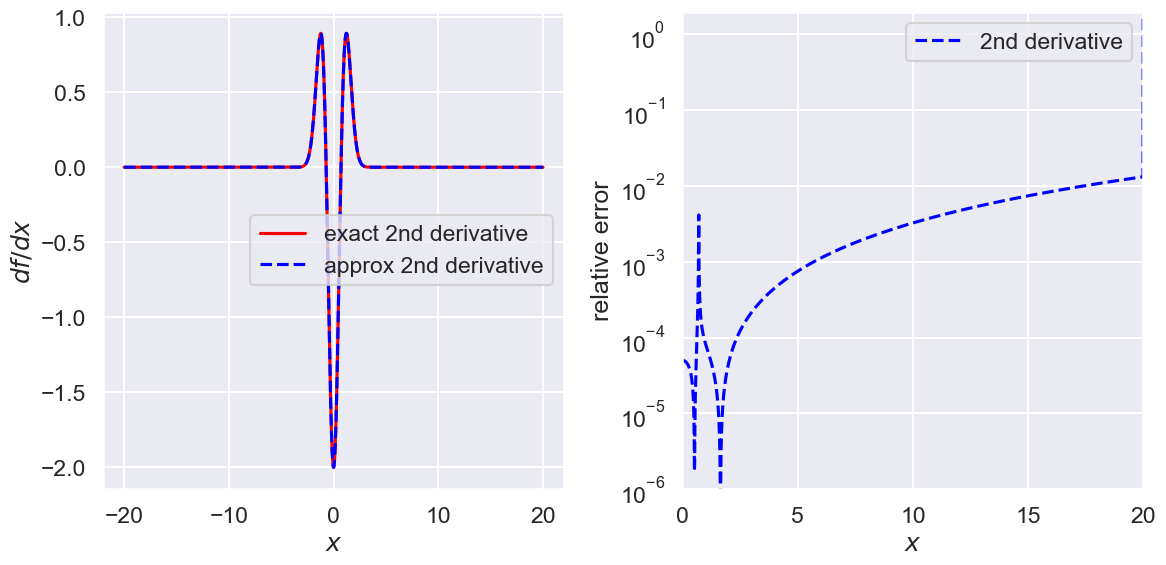

In [9]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$df/dx$')
#ax1.set_xlim(0, x_max)
#ax1.set_ylim(-1., 3)

ax1.plot(x_mesh, f_2nd_deriv_exact, color='red', label='exact 2nd derivative')
ax1.plot(x_mesh, f_2nd_deriv, color='blue', label='approx 2nd derivative', linestyle='dashed')

ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'relative error')
ax2.set_xlim(0, x_max)
ax2.set_ylim(1e-6, 2)

# Calculate relative errors
rel_error_2nd_deriv = rel_error(f_2nd_deriv_exact, f_2nd_deriv)

ax2.semilogy(x_mesh, rel_error_2nd_deriv, color='blue', label='2nd derivative', linestyle='dashed')

ax2.legend()

fig.tight_layout()

## Linear potential

The Hamiltonian matrix is 

$$
 \hat H \doteq  -\frac{\hbar^2}{2m}\frac{d^2}{dx^2} + V(x) ,
$$

which we'll implement as a sum of matrices. We'll choose units so that $\hbar^2/2m = 1$ and $\hbar\omega = 1$ (if a harmonic oscillator and other simple units if a different potential is used).

In [10]:
def V_SHO_matrix(x_mesh):
    """
    Harmonic oscillator potential matrix (defined as a diagonal matrix)
    """
    k = 1/2       # k is chosen so that hbar*omega = 1 
    V_diag = k * x_mesh**2 / 2  # diagonal matrix elements
    N = len(x_mesh)  # number of x points
    
    return V_diag * np.diag(np.ones(N), 0) 

In [11]:
def Half_V_Coulomb_matrix(x_mesh, a):
    """
    Coulomb potential matrix (defined as a diagonal matrix)
    """
    k = 10       # k is chosen so that hbar*omega = 1 
    inf = 1.e10
    #V_diag = k * x_mesh**2 / 2  # diagonal matrix elements
    V_diag = [-k / x * erf(x / (np.sqrt(2)*a)) if x > 0 else inf for x in x_mesh]  # using a list comprehension
    N = len(x_mesh)  # number of x points
    
    return V_diag * np.diag(np.ones(N), 0) 

In [12]:
def V_linear_matrix(x_mesh):
    """
    Linear potential matrix (defined as a diagonal matrix)
    """
    k = 1/2       # k is chosen for simple units
    V_diag = k * np.abs(x_mesh)  # diagonal matrix elements
    N = len(x_mesh)  # number of x points
    
    return V_diag * np.diag(np.ones(N), 0) 

In [13]:
def xsq_matrix(x_mesh):
    """
    matrix for x^2 operator
    """
    N = len(x_mesh)  # number of x points

    return x_mesh**2 * np.diag(np.ones(N), 0) 

In [14]:
def exp_xsq_matrix(x_mesh, k):
    """
    matrix for e^(-k^2 x^2/2) operator
    """
    N = len(x_mesh)  # number of x points

    return np.exp(-k**2 * x_mesh**2 / 2) * np.diag(np.ones(N), 0) 

In [15]:
def eikx_matrix(x_mesh, k):
    """
    matrix for e^{ikx} operator
    """
    N = len(x_mesh)  # number of x points

    return np.exp(1j * k * x_mesh) * np.diag(np.ones(N), 0) 

In [16]:
# Combine matrices to make the Hamiltonian matrix
a_cut = 0.001
#V_linear = V_linear_matrix(x_mesh)
V_half_Coulomb = Half_V_Coulomb_matrix(x_mesh, a_cut)

Hamiltonian = -second_deriv + V_half_Coulomb

In [17]:
# Try diagonalizing using numpy functions
eigvals, eigvecs = np.linalg.eigh(Hamiltonian)

In [18]:
gs = eigvals[0]
for n, eig in enumerate(eigvals[0:10]):
    print(f' {n}  {eig}  {eig / gs * (n+1)**2}')
print(eigvals[0:10])

 0  -24.984399019508285  1.0
 1  -6.249024307909587  1.000468220673266
 2  -2.777585070870849  1.0005550110818566
 3  -1.5624390402782464  1.000585390304255
 4  -0.9999736318419257  1.0005980442646705
 5  -0.693420520554118  0.9991490577962897
 6  -0.4799557525787488  0.9413006835984139
 7  -0.2335958401444738  0.5983787625859233
 8  0.08196118411609368  -0.2657200562727103
 9  0.46205018408767656  -1.8493548062809082
[-24.98439902  -6.24902431  -2.77758507  -1.56243904  -0.99997363
  -0.69342052  -0.47995575  -0.23359584   0.08196118   0.46205018]


Notice that they are all *above* the exact answer. Variational principle!

In [19]:
wf_0 = eigvecs[:,0]
wf_1 = eigvecs[:,1]
wf_2 = eigvecs[:,2]

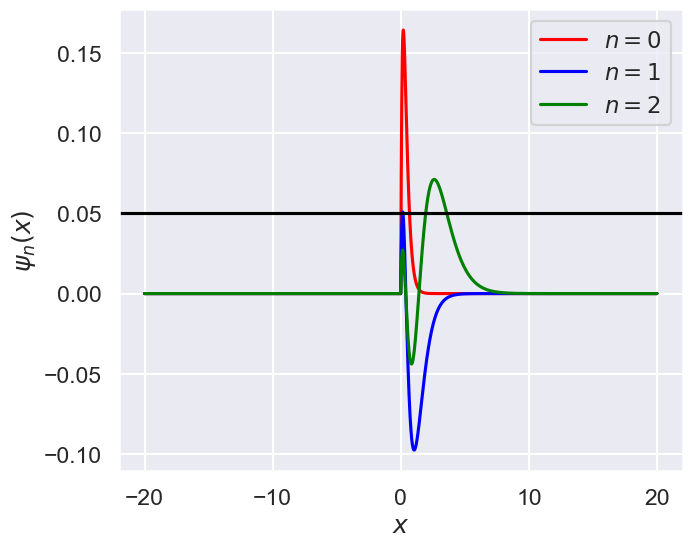

In [22]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$\psi_n(x)$')
#ax1.set_xlim(0, x_max)
#ax1.set_ylim(-1., 3)

ax1.plot(x_mesh, wf_0, color='red', label=r'$n=0$')
ax1.plot(x_mesh, wf_1, color='blue', label=r'$n=1$')
ax1.plot(x_mesh, wf_2, color='green', label=r'$n=2$')

ax1.legend();
ax1.axhline(.05, color='black')


/var/folders/1s/3wbqg65x5k79l5ww8fg25yvh0000gn/T/ipykernel_68508/3848191269.py:9: RuntimeWarning: invalid value encountered in log
  ax1.loglog(x_mesh, -np.log(wf_0), color='red', label=r'$n=0$')


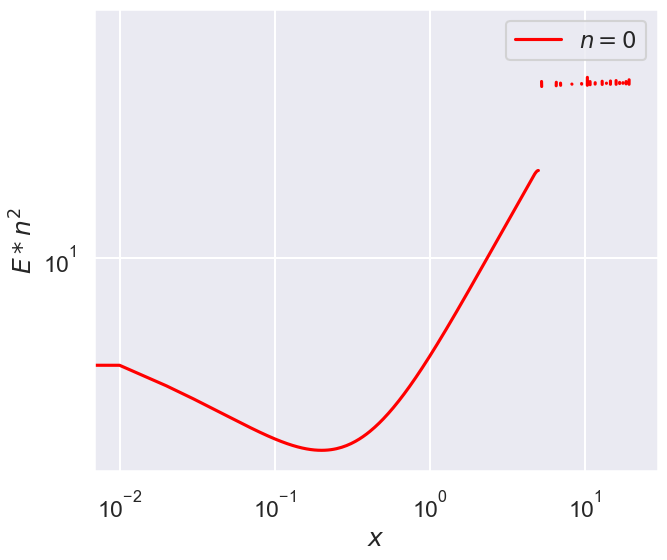

In [21]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$E * n^2$')
#ax1.set_xlim(0, x_max)
#ax1.set_ylim(-1., 3)

ax1.loglog(x_mesh, -np.log(wf_0), color='red', label=r'$n=0$')
#ax1.plot(x_mesh, wf_1, color='blue', label=r'$n=1$')
#ax1.plot(x_mesh, wf_2, color='green', label=r'$n=2$')

ax1.legend();
